In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from joblib import dump
warnings.filterwarnings('ignore')

In [10]:
# 1. Data Loading and Merging
print("Step 1: Data Loading and Merging")
df1 = pd.read_csv('data/dataset_kiriminal_prediction_fixed.csv')
df2 = pd.read_csv('data/dataset_criminal_2020_2021.csv')  

print("Dataset 1 shape:", df1.shape)
print("Dataset 2 shape:", df2.shape)

# Merge datasets
df = pd.concat([df1, df2], ignore_index=True)
print("Merged dataset shape:", df.shape)

Step 1: Data Loading and Merging
Dataset 1 shape: (238, 6)
Dataset 2 shape: (90, 6)
Merged dataset shape: (328, 6)


In [11]:
# 2. Initial Data Exploration
print("\nStep 2: Initial Data Exploration")
print("\nColumn names:")
print(df.columns)
print("\nData types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())
print("\nSummary statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())


Step 2: Initial Data Exploration

Column names:
Index(['tahun', 'tanggal_kejadian', 'jenis_kriminal', 'wilayah',
       'kepadatan_penduduk', 'pengangguran_persen'],
      dtype='object')

Data types:
tahun                    int64
tanggal_kejadian        object
jenis_kriminal          object
wilayah                 object
kepadatan_penduduk       int64
pengangguran_persen    float64
dtype: object

First few rows:
   tahun tanggal_kejadian jenis_kriminal        wilayah  kepadatan_penduduk  \
0   2022       2022-03-24        SEKSUAL  JAKARTA BARAT             2458707   
1   2022       2022-05-18        SEKSUAL  JAKARTA BARAT             2458707   
2   2022       2022-05-25     KDRT FISIK  JAKARTA BARAT             2458707   
3   2022       2022-06-29         PSIKIS  JAKARTA BARAT             2458707   
4   2022       2022-07-07     KDRT FISIK  JAKARTA BARAT             2458707   

   pengangguran_persen  
0                  7.1  
1                  7.1  
2                  7.1  
3     

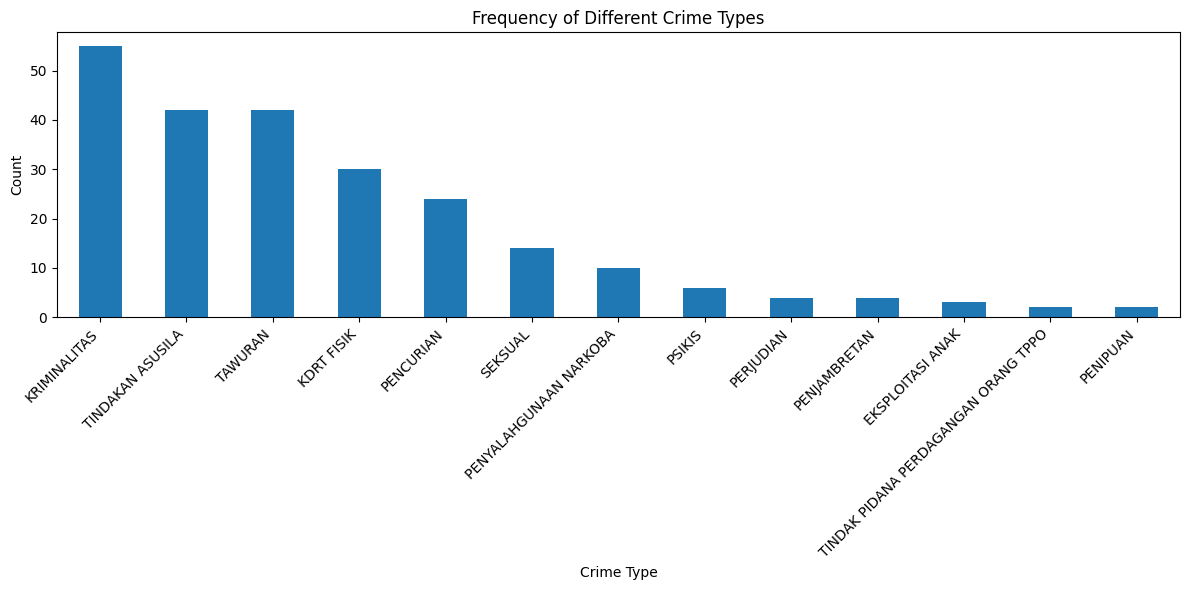

In [6]:
#Analyze crime frequency
crime_counts = df['jenis_kriminal'].value_counts()
plt.figure(figsize=(12, 6))
crime_counts.plot(kind='bar')
plt.title('Frequency of Different Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

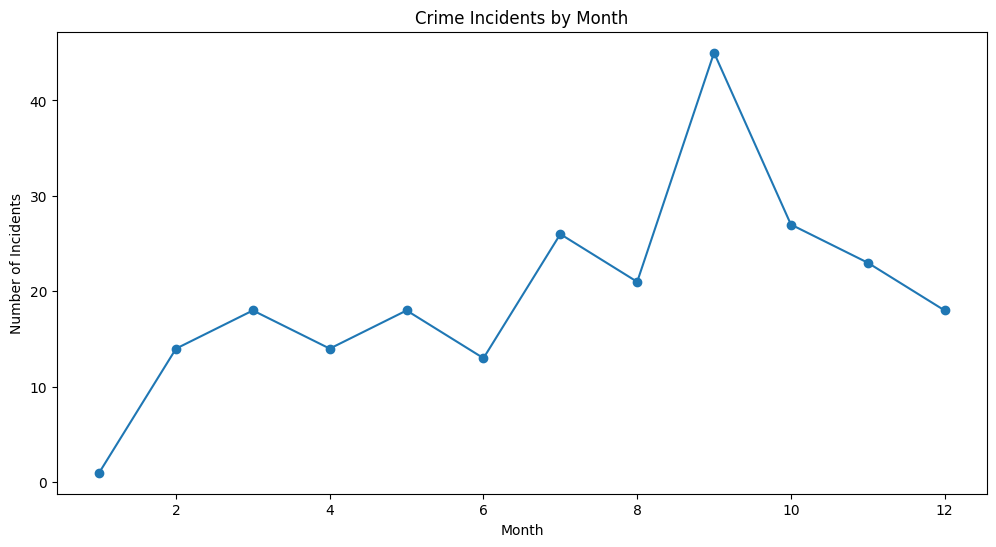

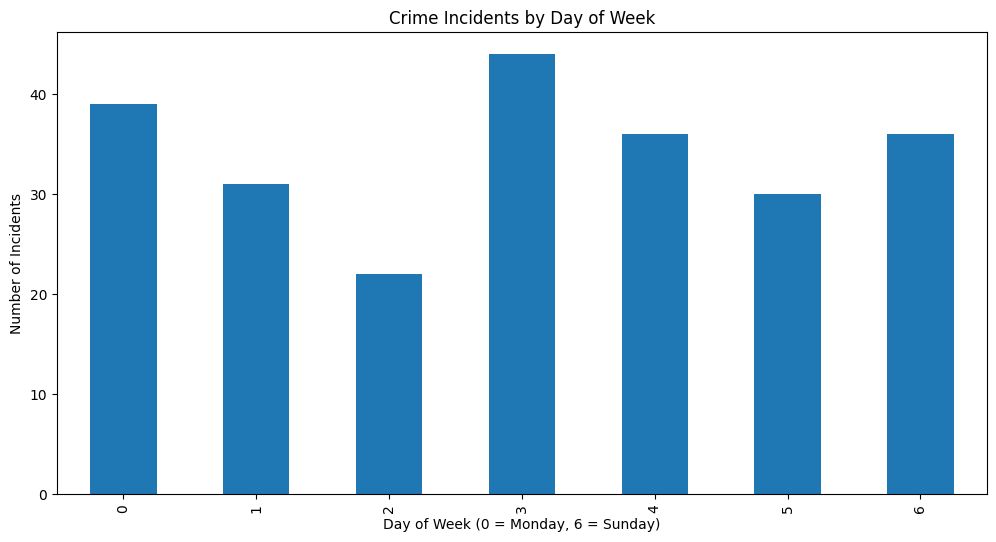

In [7]:
# Crime by month
monthly_crime = df.groupby('month')['jenis_kriminal'].count()
plt.figure(figsize=(12, 6))
monthly_crime.plot(kind='line', marker='o')
plt.title('Crime Incidents by Month')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.show()

# Crime by day of week
daily_crime = df.groupby('day_of_week')['jenis_kriminal'].count()
plt.figure(figsize=(12, 6))
daily_crime.plot(kind='bar')
plt.title('Crime Incidents by Day of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Number of Incidents')
plt.show()

In [12]:
# 3. Data Preprocessing
print("\nStep 3: Data Preprocessing")
# Convert date to datetime
df['tanggal_kejadian'] = pd.to_datetime(df['tanggal_kejadian'])
df['year'] = df['tanggal_kejadian'].dt.year
df['month'] = df['tanggal_kejadian'].dt.month
df['day'] = df['tanggal_kejadian'].dt.day
df['day_of_week'] = df['tanggal_kejadian'].dt.dayofweek

print("Date range:", df['tanggal_kejadian'].min(), "to", df['tanggal_kejadian'].max())


Step 3: Data Preprocessing
Date range: 2020-01-07 00:00:00 to 2023-12-17 00:00:00


In [13]:
# Function to detect outliers using IQR method
def detect_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

# Detect and print outliers in unemployment rate for each year
for year in df['year'].unique():
    year_data = df[df['year'] == year]
    outliers = detect_outliers(year_data['pengangguran_persen'])
    print(f"Year {year}: {outliers.sum()} outliers detected")

# Instead of replacing outliers, we'll create a new column for adjusted unemployment
df['adjusted_unemployment'] = df['pengangguran_persen']

Year 2022: 0 outliers detected
Year 2023: 0 outliers detected
Year 2020: 0 outliers detected
Year 2021: 9 outliers detected


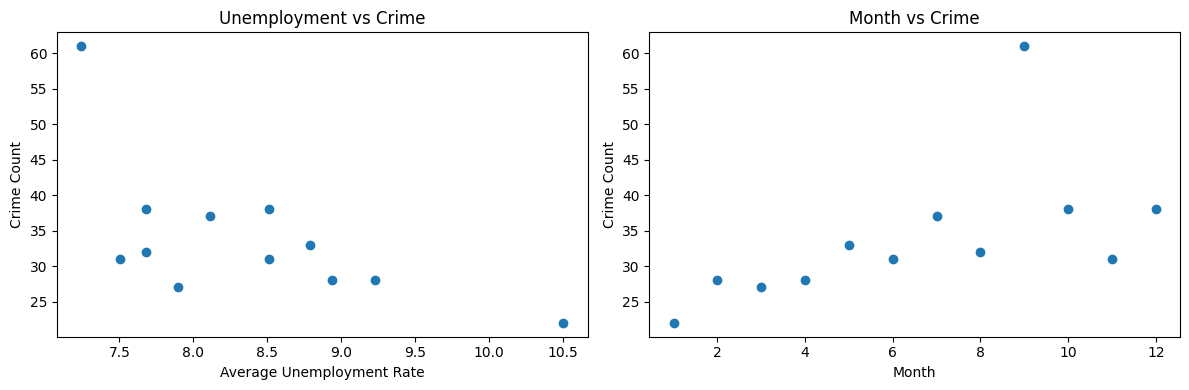

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(monthly_data['avg_pengangguran_persen'], monthly_data['crime_count'])
plt.xlabel('Average Unemployment Rate')
plt.ylabel('Crime Count')
plt.title('Unemployment vs Crime')

plt.subplot(122)
plt.scatter(monthly_data['month'], monthly_data['crime_count'])
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.title('Month vs Crime')
plt.tight_layout()
plt.show()

Unemployment Percentages by Region, Month, and Year:
----------------------------------------------------
2020-01 | JAKARTA BARAT        | 10.20%
2020-01 | JAKARTA PUSAT        | 13.40%
2020-01 | JAKARTA SELATAN      | 12.00%
2020-01 | JAKARTA TIMUR        | 8.40%
2020-01 | JAKARTA UTARA        | 12.25%
2020-02 | JAKARTA BARAT        | 13.10%
2020-02 | JAKARTA PUSAT        | 11.40%
2020-02 | JAKARTA SELATAN      | 14.23%
2020-02 | JAKARTA TIMUR        | 12.25%
2020-02 | JAKARTA UTARA        | 10.50%
2020-03 | JAKARTA BARAT        | 12.20%
2020-03 | JAKARTA PUSAT        | 9.40%
2020-03 | JAKARTA SELATAN      | 9.63%
2020-04 | JAKARTA BARAT        | 12.20%
2020-04 | JAKARTA PUSAT        | 13.10%
2020-04 | JAKARTA SELATAN      | 14.50%
2020-04 | JAKARTA TIMUR        | 12.43%
2020-04 | JAKARTA UTARA        | 13.00%
2020-05 | JAKARTA BARAT        | 11.60%
2020-05 | JAKARTA PUSAT        | 12.97%
2020-05 | JAKARTA SELATAN      | 12.23%
2020-05 | JAKARTA TIMUR        | 12.50%
2020-06 | JAKARTA

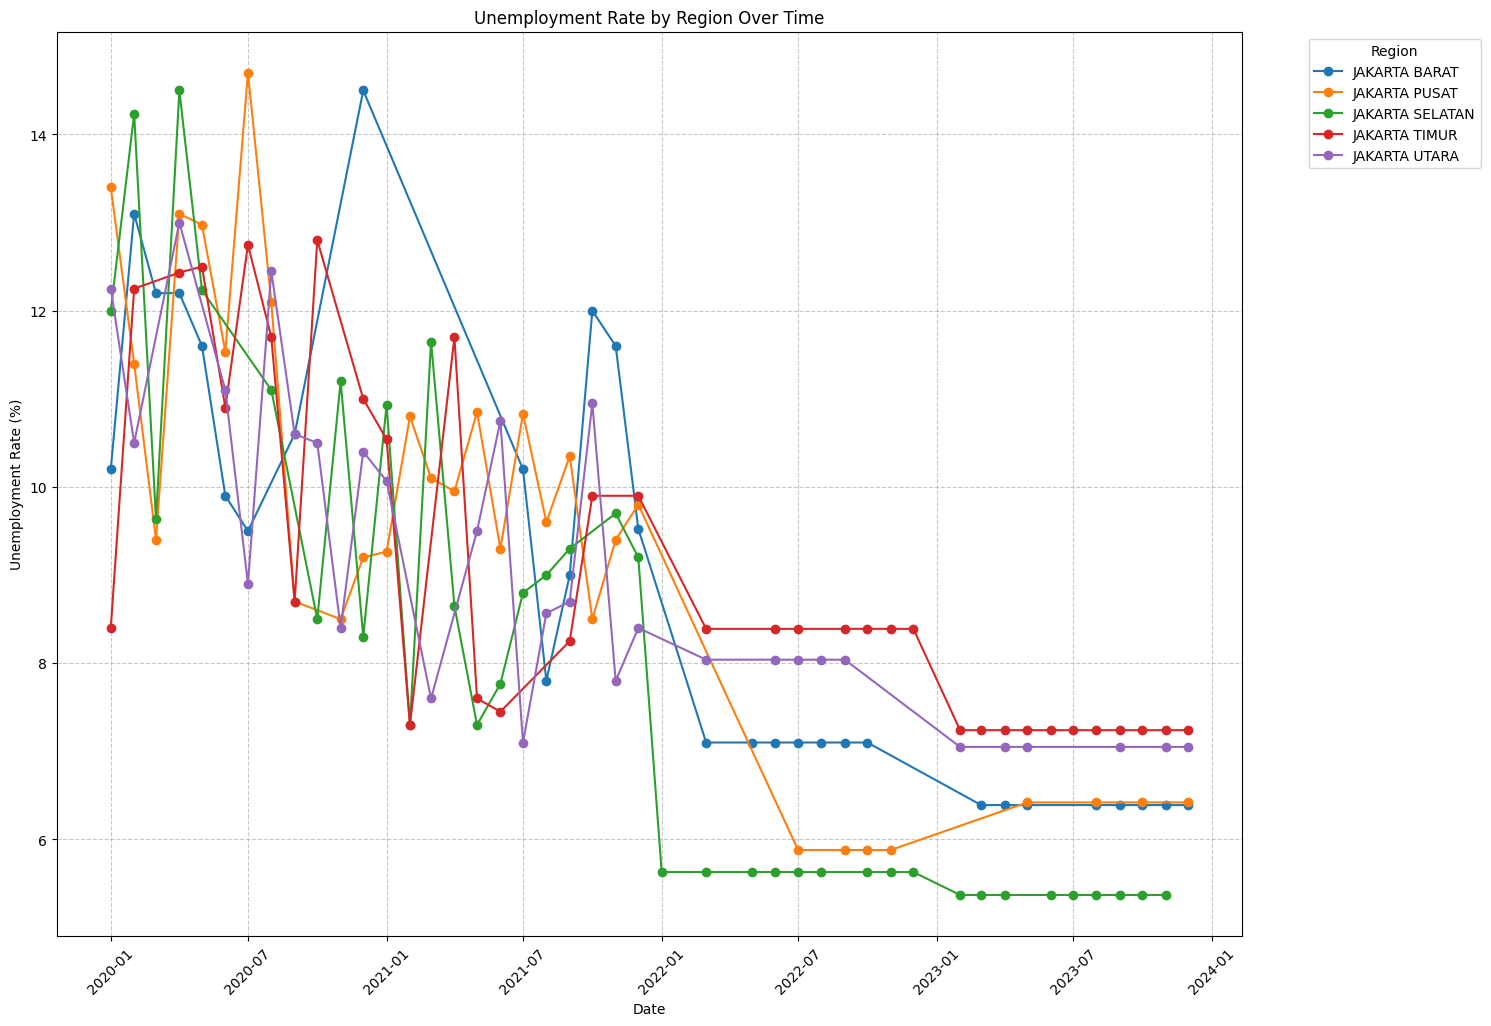

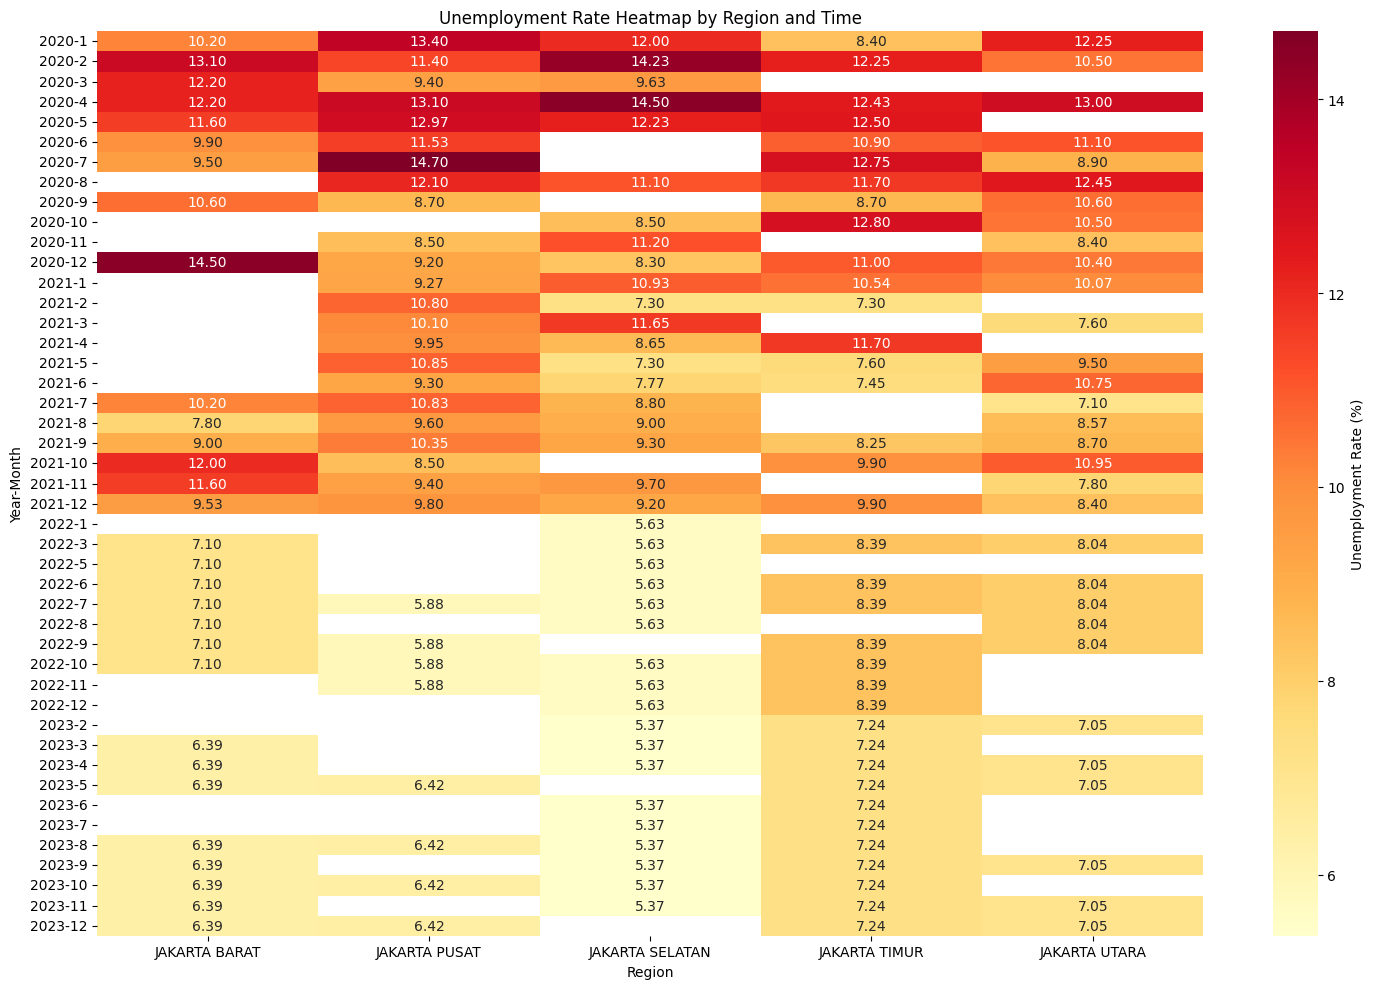

In [8]:
# Convert 'tanggal_kejadian' to datetime 
df['tanggal_kejadian'] = pd.to_datetime(df['tanggal_kejadian'])

# Extract year and month
df['year'] = df['tanggal_kejadian'].dt.year
df['month'] = df['tanggal_kejadian'].dt.month

# Group by year, month, and region, taking the mean of unemployment percentage
unemployment_data = df.groupby(['year', 'month', 'wilayah'])['pengangguran_persen'].mean().reset_index()

# Sort the data chronologically
unemployment_data = unemployment_data.sort_values(['year', 'month'])

# Display the results
print("Unemployment Percentages by Region, Month, and Year:")
print("----------------------------------------------------")
for _, row in unemployment_data.iterrows():
    print(f"{row['year']}-{row['month']:02d} | {row['wilayah']: <20} | {row['pengangguran_persen']:.2f}%")

# Visualize the data
plt.figure(figsize=(15, 10))
for region in unemployment_data['wilayah'].unique():
    region_data = unemployment_data[unemployment_data['wilayah'] == region]
    plt.plot(pd.to_datetime(region_data['year'].astype(str) + '-' + region_data['month'].astype(str).str.zfill(2) + '-01'), 
             region_data['pengangguran_persen'], 
             label=region, marker='o')

plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.title('Unemployment Rate by Region Over Time')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Heatmap visualization
pivot_data = unemployment_data.pivot(index=['year', 'month'], columns='wilayah', values='pengangguran_persen')
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Unemployment Rate (%)'})
plt.title('Unemployment Rate Heatmap by Region and Time')
plt.ylabel('Year-Month')
plt.xlabel('Region')
plt.tight_layout()
plt.show()

In [17]:
df['is_pandemic'] = ((df['year'] == 2020) & (df['month'] >= 3)) | (df['year'] == 2021)

normal_unemployment = df[~df['is_pandemic']].groupby('wilayah')['pengangguran_persen'].mean()
df['adjusted_unemployment'] = df.apply(lambda row: normal_unemployment[row['wilayah']] if row['is_pandemic'] else row['pengangguran_persen'], axis=1)

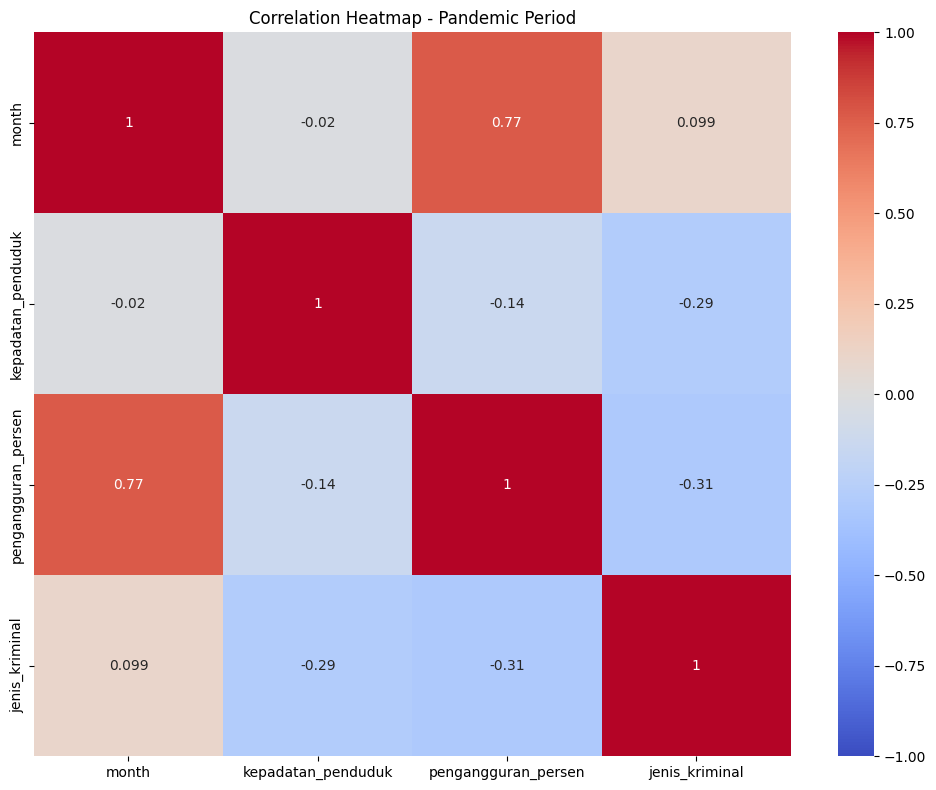


Key correlations for Pandemic period:
Unemployment and Crime: -0.31
Month and Crime: 0.10


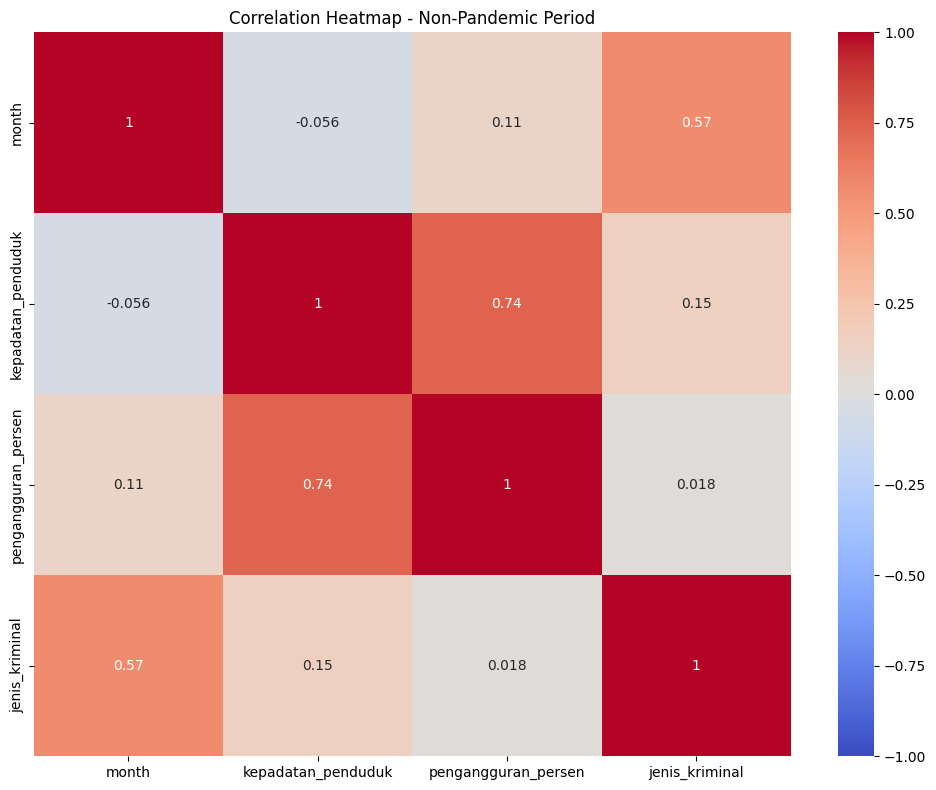


Key correlations for Non-Pandemic period:
Unemployment and Crime: 0.02
Month and Crime: 0.57


In [16]:
# Split data into pandemic and non-pandemic periods
pandemic_data = df[df['is_pandemic']]
non_pandemic_data = df[~df['is_pandemic']]

# Analyze each period separately
for period, data in [("Pandemic", pandemic_data), ("Non-Pandemic", non_pandemic_data)]:
    monthly_data = data.groupby('month').agg({
        'kepadatan_penduduk': 'mean',
        'pengangguran_persen': 'mean',
        'jenis_kriminal': 'count'
    }).reset_index()
    
    correlation_matrix = monthly_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap - {period} Period')
    plt.tight_layout()
    plt.show()
    
    print(f"\nKey correlations for {period} period:")
    print(f"Unemployment and Crime: {correlation_matrix.loc['pengangguran_persen', 'jenis_kriminal']:.2f}")
    print(f"Month and Crime: {correlation_matrix.loc['month', 'jenis_kriminal']:.2f}")


Revised correlations:
Time and Crime: 0.67
Adjusted Unemployment and Crime: -0.11


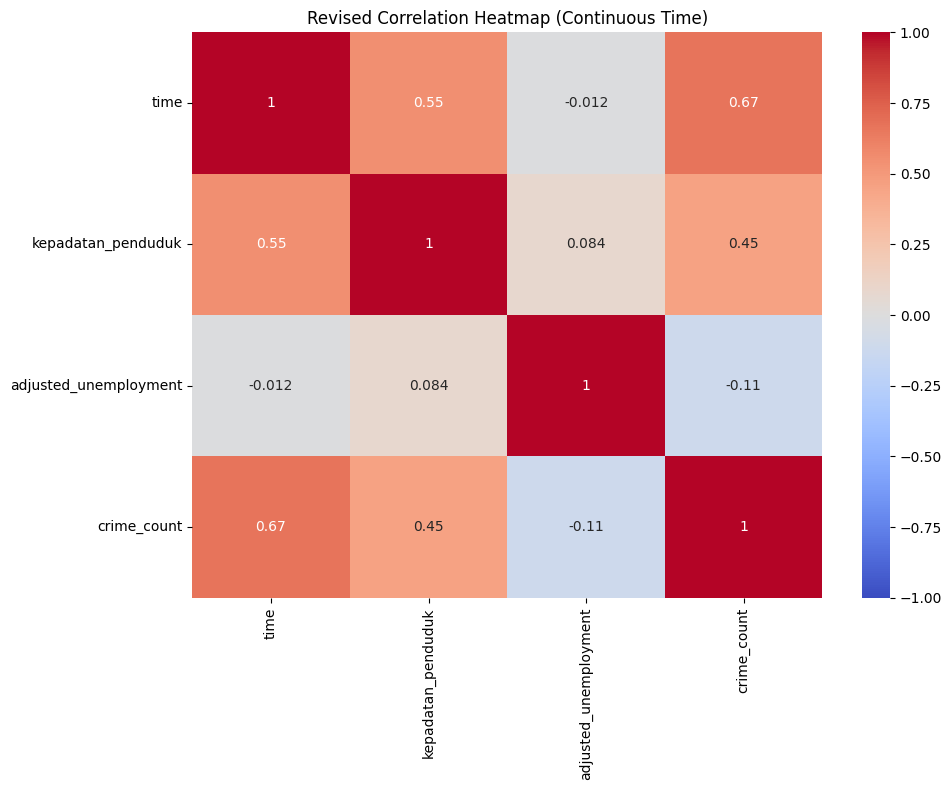

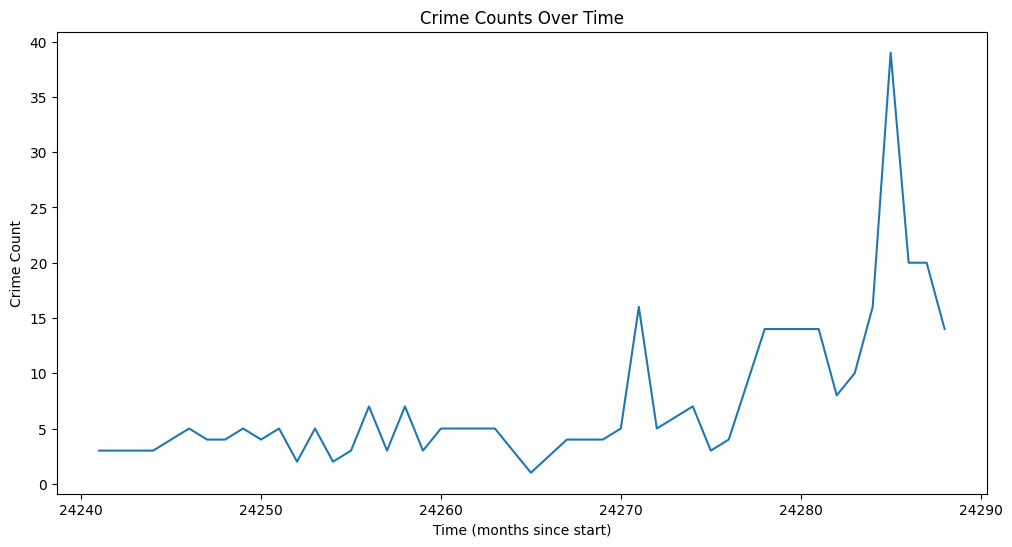

In [20]:
# Instead of using just 'month', let's create a continuous time variable
df['time'] = df['year'] * 12 + df['month']

monthly_data = df.groupby(['year', 'month', 'time']).agg({
    'kepadatan_penduduk': 'mean',
    'adjusted_unemployment': 'mean',
    'crime_count': 'sum'
}).reset_index()

# Recalculate correlation
correlation_matrix = monthly_data[['time', 'kepadatan_penduduk', 'adjusted_unemployment', 'crime_count']].corr()

print("\nRevised correlations:")
print(f"Time and Crime: {correlation_matrix.loc['time', 'crime_count']:.2f}")
print(f"Adjusted Unemployment and Crime: {correlation_matrix.loc['adjusted_unemployment', 'crime_count']:.2f}")

# Plot new heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Revised Correlation Heatmap (Continuous Time)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(monthly_data['time'], monthly_data['crime_count'])
plt.title('Crime Counts Over Time')
plt.xlabel('Time (months since start)')
plt.ylabel('Crime Count')
plt.show()

In [21]:
df['time'] = df['year'] * 12 + df['month']
df['is_weekend'] = df['tanggal_kejadian'].dt.dayofweek.isin([5, 6]).astype(int)

# Aggregate data monthly
monthly_data = df.groupby(['year', 'month', 'time']).agg({
    'kepadatan_penduduk': 'mean',
    'adjusted_unemployment': 'mean',
    'crime_count': 'sum',
    'is_weekend': 'mean'
}).reset_index()

# Create lag features
for lag in [1, 2, 3]:
    monthly_data[f'crime_lag_{lag}'] = monthly_data['crime_count'].shift(lag)

monthly_data = monthly_data.dropna()  # Remove rows with NaN from lag creation

# Prepare features for modeling
features = ['time', 'kepadatan_penduduk', 'adjusted_unemployment', 'is_weekend', 
            'crime_lag_1', 'crime_lag_2', 'crime_lag_3']
X = monthly_data[features]
y = monthly_data['crime_count']

In [22]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 13.282812500000002
R-squared Score: 0.5671588594704684


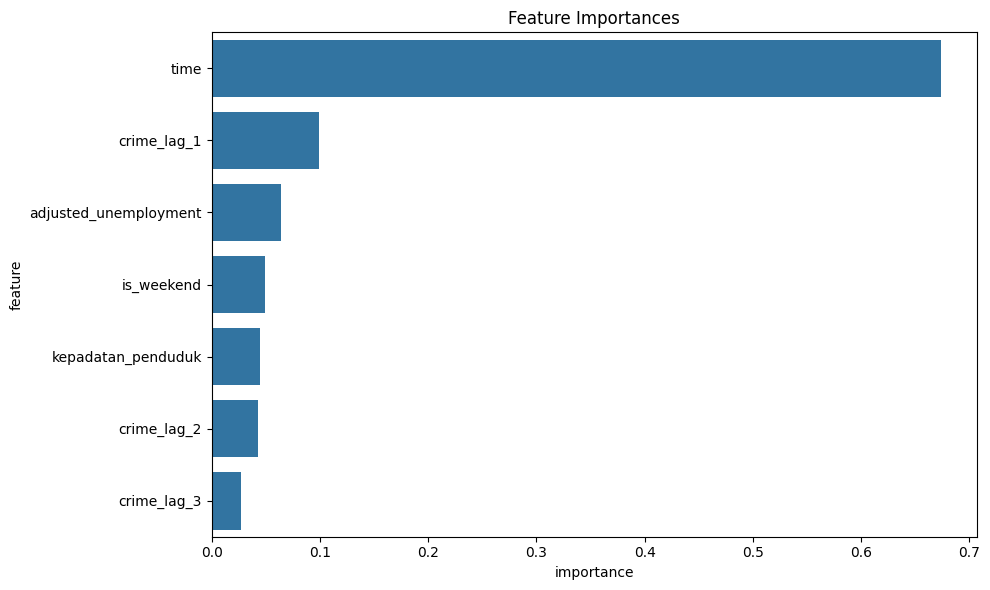

In [23]:
# Get feature importances
importances = rf_model.feature_importances_
feature_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_imp = feature_imp.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

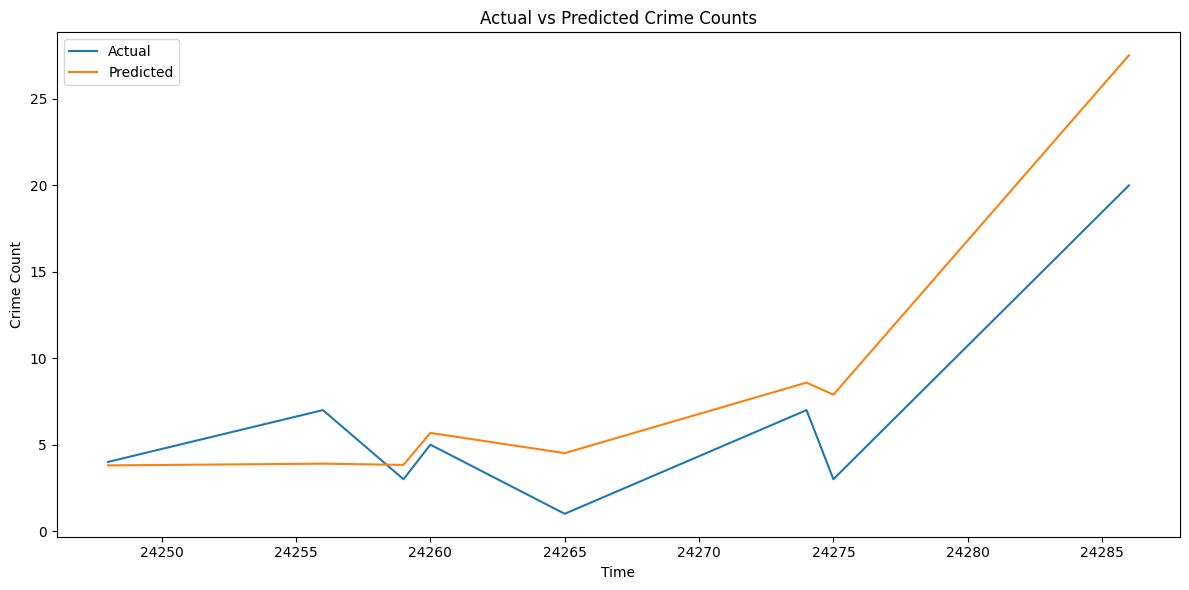

In [24]:
# Combine actual and predicted values
results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
}, index=X_test.index)
results = results.sort_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.loc[results.index, 'time'], results['actual'], label='Actual')
plt.plot(monthly_data.loc[results.index, 'time'], results['predicted'], label='Predicted')
plt.title('Actual vs Predicted Crime Counts')
plt.xlabel('Time')
plt.ylabel('Crime Count')
plt.legend()
plt.tight_layout()
plt.show()

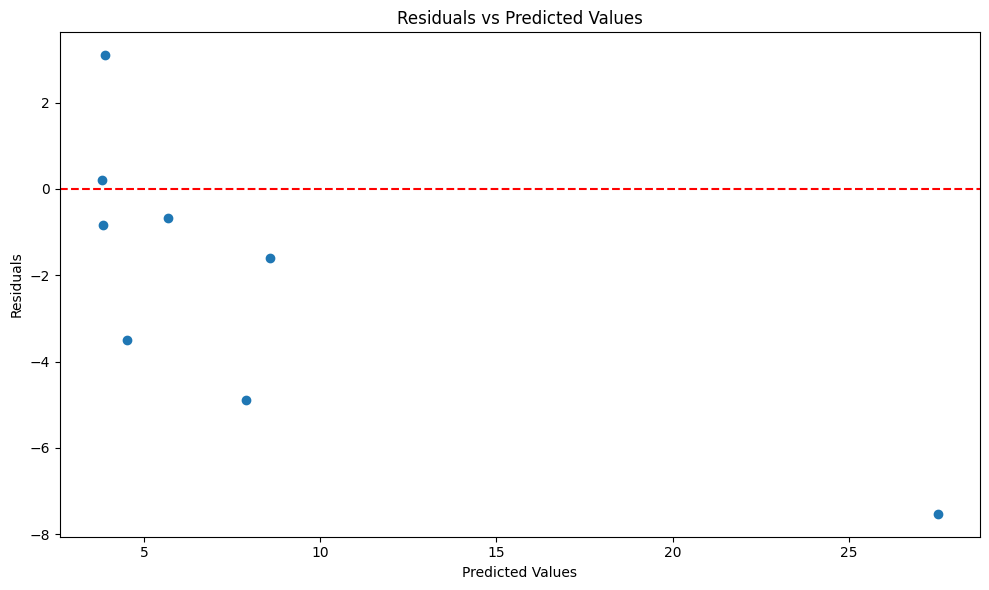

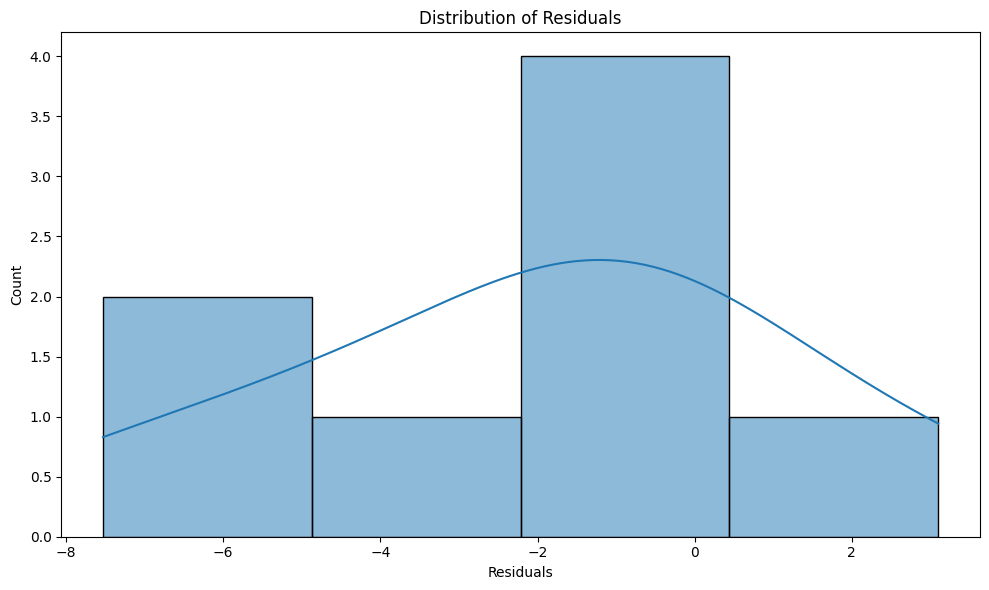

In [25]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.tight_layout()
plt.show()

In [26]:
print("Model Insights:")
print(f"1. The model explains {r2:.2%} of the variance in crime counts.")
print(f"2. The top 3 important features are: {', '.join(feature_imp['feature'].head(3))}")
print("3. Time-based features and previous crime counts seem to be strong predictors.")
print("4. Adjusted unemployment rate has a relatively low importance, confirming our earlier observation.")
print("\nRecommendations:")
print("1. Focus on temporal patterns and recent crime history for prediction.")
print("2. Consider external factors not in the current dataset that might explain the recent increase in crime.")
print("3. Investigate local policies or socio-economic changes that coincide with crime rate changes.")
print("4. Regularly update the model with new data to capture evolving trends.")

Model Insights:
1. The model explains 56.72% of the variance in crime counts.
2. The top 3 important features are: time, crime_lag_1, adjusted_unemployment
3. Time-based features and previous crime counts seem to be strong predictors.
4. Adjusted unemployment rate has a relatively low importance, confirming our earlier observation.

Recommendations:
1. Focus on temporal patterns and recent crime history for prediction.
2. Consider external factors not in the current dataset that might explain the recent increase in crime.
3. Investigate local policies or socio-economic changes that coincide with crime rate changes.
4. Regularly update the model with new data to capture evolving trends.


In [29]:
dump(rf_model, 'crime_prediction_model.joblib')
dump(scaler, 'feature_scaler.joblib')

# Export feature names
with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(features))

# Export model performance metrics
performance = {
    'mse': mse,
    'r2': r2,
    'feature_importance': feature_imp.to_dict()
}
dump(performance, 'model_performance.joblib')

print("Model and related components exported successfully.")

Model and related components exported successfully.
